## LQR Example

This notebook demonstrates how to solve a finite-horizon Linear Quadratic Regulator (LQR) problem using a Gaussian Factor Graph in GTSAM. The goal is to minimize a quadratic cost w.r.t. dynamics constraints over a linear dynamical system using factor-graph-based optimization. The results are compared against results from classical Riccati equations. Adapted from https://gtsam.org/2019/11/07/lqr-control.html

Author(s): [Zhouyu Zhang](https://zhangzdd.github.io/zzy_webpage/)

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/python/gtsam/examples/LQRExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GTSAM Copyright 2010-2025, Georgia Tech Research Corporation, Atlanta, Georgia 30332-0415 All Rights Reserved

Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

In [1]:
# In colab install gtsam and gtbook
try:
    import google.colab
    %pip install --quiet gtsam-develop
    %pip install --quiet gtbook
except ImportError:
    pass # Not in Colab


Proceed (Y/n)? y
Proceed (Y/n)? y


In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import gtsam
from gtsam import symbol
from gtsam.symbol_shorthand import X, U
import graphviz
from gtbook.display import show

# Discrete-Time State-Space Form (2D State: Position and Velocity)
We look to work on a 1D double integrator system, in this sense, we define the state and input as:

$$
x_k = \begin{bmatrix} x \\ \dot{x} \end{bmatrix}, \quad u_k = \ddot{x}
$$

We can think of it as a linear vehicle for which we can control the gas paddle (acceleration). Then the discrete-time dynamics become:

$$
x_{k+1} = A x_k + B u_k
$$

Where:

$$
A = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}, \quad
B = \begin{bmatrix} \frac{1}{2} \Delta t^2 \\ \Delta t \end{bmatrix}
$$

So:

$$
\begin{bmatrix} x_{k+1} \\ \dot{x}_{k+1} \end{bmatrix}
=
\begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}
\begin{bmatrix} x_k \\ \dot{x}_k \end{bmatrix}
+
\begin{bmatrix} \frac{1}{2} \Delta t^2 \\ \Delta t \end{bmatrix} u_k
$$


# LQR Problem Setup

We seek to minimize the infinite-horizon cost function:

$$
J = \sum_{k=0}^\infty \left( x_k^\top Q x_k + u_k^\top R u_k \right)
$$

Choose the weighting matrices:

$$
Q = \begin{bmatrix} q_1 & 0 \\ 0 & q_2 \end{bmatrix}, \quad
R = r
$$

- $ Q \succeq 0 $: penalizes position and velocity
- $ R \succ 0 $: penalizes control effort




In [3]:
# Define system dynamics: x_{k+1} = A x_k + B u_k
A = np.array([[1.0, 0.1],
        [0.0, 1.0]])
B = np.array([[0.005],
        [1.0]])

# Define cost matrices: minimize sum of (xᵀQx + uᵀRu)
Q = np.eye(2)
R = np.array([[1.0]])



###  Graphical Model Representation of Finite-Horizon LQR

We formulate the finite-horizon Linear Quadratic Regulator (LQR) problem as a **factor graph**, allowing us to interpret optimal control as a **maximum a posteriori (MAP)** estimation problem.

---

###  Problem Statement

Given discrete-time linear dynamics:

$$
x_{k+1} = A x_k + B u_k
$$

and a quadratic cost function:

$$
J(x, u) = \sum_{k=0}^{N-1} \left( x_k^\top Q x_k + u_k^\top R u_k \right) + x_N^\top Q x_N
$$

we aim to find the state-control sequence $ \{x_k, u_k\}_{k=0}^{N-1} $ minimizing $ J $, subject to initial state $ x_0 $ and dynamics.

---

### MAP Estimation View

This control problem is equivalent to a **MAP estimation** over a factor graph:

$$
\arg\max_{x_{0:N}, u_{0:N-1}} \; p(x_{0:N}, u_{0:N-1} \mid \text{costs, dynamics})
$$

This posterior can be written as a product of factors:

$$
p(x, u) \propto \phi_0(x_0)
\prod_{k=0}^{N-1} \phi_Q(x_k) \phi_R(u_k) \phi_f(x_k, u_k, x_{k+1})
\cdot \phi_Q(x_N)
$$

---

###  Prior Factor (Initial Condition)

We encode the prior on the initial state as a Gaussian:

$$
\phi_0(x_0) \propto \exp\left( -\frac{1}{2} \| x_0 - x_{\text{init}} \|^2_{\Sigma_0} \right)
$$

where $ \Sigma_0 \approx 0 \cdot I $ enforces the initial condition tightly.

---

###  Quadratic Cost Factors

Each quadratic cost $ x_k^\top Q x_k $ is rewritten via Cholesky decomposition $ Q = L_x^\top L_x $ as:

$$
x_k^\top Q x_k = \| L_x x_k \|^2 \quad \Rightarrow \quad
\phi_Q(x_k) \propto \exp\left( -\frac{1}{2} \| L_x x_k \|^2 \right)
$$

Similarly, for control:

$$
\phi_R(u_k) \propto \exp\left( -\frac{1}{2} \| L_u u_k \|^2 \right), \quad R = L_u^\top L_u
$$

These are **soft constraints**, penalizing deviation from zero.

---

###  Dynamics Constraints (Hard Constraints)

Each dynamics equation:

$$
x_{k+1} = A x_k + B u_k
$$

is encoded as a **hard constraint**, modeled as a Gaussian with **zero variance**:

$$
\phi_f(x_k, u_k, x_{k+1}) \propto \delta(x_{k+1} - A x_k - B u_k)
= \lim_{\Sigma \to 0} \exp\left( -\frac{1}{2} \| x_{k+1} - A x_k - B u_k \|^2_{\Sigma} \right)
$$

This enforces the equality exactly during optimization.

---

###  Terminal Cost

The terminal cost is also encoded as a soft quadratic factor:

$$
\phi_Q(x_N) \propto \exp\left( -\frac{1}{2} \| L_x x_N \|^2 \right)
$$




In [4]:
# Horizon of the problem (i.e. how many discrete timesteps we want to consider)
# Note that in python the initial index starts at 0, so the terminal states would be N-1
N = 4
# Cost factors: L such that Q = LᵀL
Lx = np.linalg.cholesky(Q)
Lu = np.linalg.cholesky(R)

# Create a Gaussian factor graph for the linear-quadratic problem
graph = gtsam.GaussianFactorGraph()
initial_values = gtsam.Values()

# Set initial state: x_0 = [0, 1]^T, add a strong prior factor to fix the initial state
x0 = np.array([0.0, 1.0])
prior_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1e-20)
graph.add(gtsam.JacobianFactor(X(0), np.eye(2), x0, prior_noise))

# Cost + dynamics
for k in range(N):
    xk = X(k)
    uk = U(k)

    # Cost factor: x_k^T Q x_k
    graph.add(gtsam.JacobianFactor(xk, Lx, np.zeros(2), gtsam.noiseModel.Unit.Create(2)))

    # Cost factor: u_k^T R u_k, note that there is no cost term for terminal input
    if k < N-1:
        graph.add(gtsam.JacobianFactor(uk, Lu, np.zeros(1), gtsam.noiseModel.Unit.Create(1)))

    # Dynamics hard constraint factor: x_{k+1} = A x_k + B u_k
    if k <= N-2:
        xk1 = X(k+1)
        graph.add(gtsam.JacobianFactor(
            xk1, np.eye(2),
            xk, -A,
            uk, -B,
            np.zeros((2, 1)),
            gtsam.noiseModel.Diagonal.Sigmas(np.zeros(2))  # hard constraint
        ))

# Terminal cost: x_N-1^T Q x_N-1
xN = X(N-1)
graph.add(gtsam.JacobianFactor(xN, Lx, np.zeros(2), gtsam.noiseModel.Unit.Create(2)))

array([[0.        , 1.        ],
       [0.0968027 , 0.36053946],
       [0.13167395, 0.12400146],
       [0.14365837, 0.04085496]])

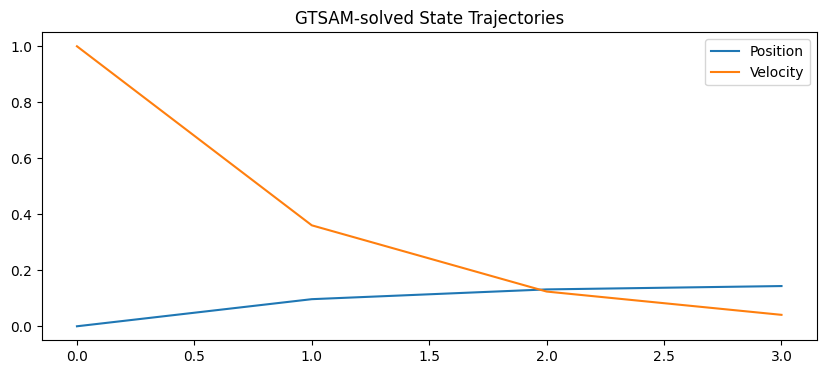

In [5]:
# Solve the factor graph and retrieve the results
result = graph.optimize()

states = []
controls = []
for k in range(N):
    xk = X(k)
    uk = U(k)
    states.append(result.at(xk))
    if k < N-1:
      controls.append(result.at(uk))


states = np.array(states)
controls = np.array(controls)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(states[:, 0], label='Position')
plt.plot(states[:, 1], label='Velocity')
plt.title('GTSAM-solved State Trajectories')
plt.legend()
states


###  Visualizing the Factor Graph and Variable Elimination (Bayes Net)

####  Initial Factor Graph

The first plot generated by `graphviz.Source(graph.dot())` visualizes the **factor graph** representation of the LQR problem.

- **Ellipses** represent variable nodes: states $ x_k $ and controls $ u_k $.
- **Black dots** are factor nodes connecting variables — each represents either:
  - A cost factor (state or control penalty),
  - A dynamics constraint,
  - Or a prior (for $ x_0 $).

The structure reflects the temporal nature of the problem:
- Each state $ x_k $ is connected to its predecessor and successor via dynamics,
- Each control $ u_k $ connects two consecutive states,
- Cost factors attach individually to each $ x_k $ and $ u_k $.



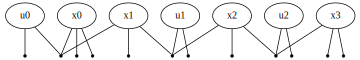

In [6]:
graphviz.Source(graph.dot())

###  From Factor Graph to Bayes Net via Variable Elimination

After constructing a Gaussian factor graph to represent the finite-horizon LQR problem, we can use GTSAM's `eliminateSequential(ordering)` to transform the factor graph into a **Bayes Net** — a directed acyclic graphical model representing the posterior distribution over all variables in a factored form.

The following plots will visualize the **Bayes Net** obtained using the elimination order:

$$
\text{Ordering} = [x_0, u_0, x_1, u_1, x_2, u_2, x_3]
$$

---

###  Structure of the Bayes Net

Each node in the plot represents a **variable**, and each arrow represents a **dependency** in a conditional Gaussian distribution arising from the variable elimination process. For example:

- $ x_2 \leftarrow \{x_3, u_2\} $  
  ⇒ $ p(x_2 \mid x_3, u_2) $
- $ u_1 \leftarrow \{x_2\} $  
  ⇒ $ p(u_1 \mid x_2) $
  
This structure means that once we solve for the "latest" variable (e.g., $ x_3 $), we can **back-substitute** through the DAG to recover the entire trajectory.

---

### What Does Elimination Do?

In mathematical terms, elimination rewrites the joint Gaussian density:

$
p(x_0, u_0, x_1, u_1, \dots, x_N) \propto \prod_i \phi_i(x_i, u_i)
$

as a sequence of **conditionals**:

$
p(x_0, u_0, x_1, \dots) = p(x_3) \cdot p(x_2 \mid x_3, u_2) \cdot \dots \cdot p(x_0)
$

Each conditional is Gaussian:

$
x_k = A_k \cdot \text{Parents}(x_k) + \eta_k, \quad \eta_k \sim \mathcal{N}(0, \Sigma_k)
$

This allows us to represent the problem as a **triangular system**, suitable for efficient solving.

---

###  Effect of Elimination Ordering

####  Will the result (optimal trajectory) change if we change the elimination ordering?

No — the **MAP solution** is invariant under ordering for **linear-Gaussian systems**, because the solution to:

$$
\min_x \|Ax - b\|^2
$$

is unique and does **not** depend on the factorization path.

####  What changes?

1. **Structure of the Bayes Net**:  
   The set of conditionals and their dependencies change. E.g., if we eliminate all controls first, each $ u_k $ may depend on more than just $ x_k $, introducing wider conditionals.

2. **Computational efficiency**:  
   Different orderings lead to different **fill-in patterns** during matrix factorization (e.g., Cholesky). A poor ordering increases memory and time.

3. **Sparsity pattern**:  
   An optimized ordering (e.g., using COLAMD or METIS) maintains sparse Jacobians and minimal cross-dependencies.

4. **Numerical stability** (nonlinear problems):  
   Poor ordering may lead to ill-conditioned systems or less stable Gauss-Newton updates.

---

###  Analogy to QR/Cholesky

The process is equivalent to **structured Gaussian elimination** or **QR factorization** of the system $ Ax = b $, where variable elimination corresponds to pivoting rows and columns of the matrix in a specific order.


In [7]:
ordering = gtsam.Ordering()
for k in range(N):
  ordering.push_back(X(k))
  if k < N-1:
    ordering.push_back(U(k))


# Generate a reversed ordering from above order
ordering_reversed = gtsam.Ordering()
for k in range(N-1, -1, -1):
  ordering_reversed.push_back(X(k))
  if k > 0:
    ordering_reversed.push_back(U(k-1))



print("Ordering:", ordering_reversed)

Ordering: Position 0: x3, u2, x2, u1, x1, u0, x0



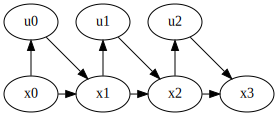

In [8]:
dag = graph.eliminateSequential(ordering_reversed)
show(dag, hints={"u":1, "x":0})

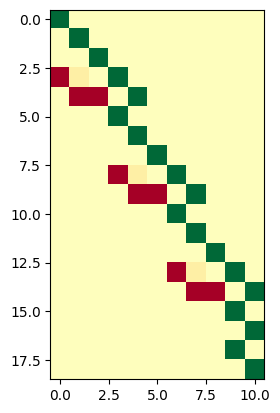

In [9]:
# The sparse matrix reprenstation of the system
plt.imshow(graph.jacobian(ordering)[0][2:,:], cmap="RdYlGn")

New Ordering: Position 0: x3, x2, x1, x0, u2, u1, u0



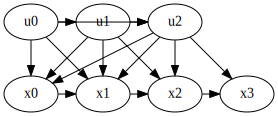

In [10]:
# The resulting Bayesian graph under a different ordering
# The resulting dependency would change, like we have described before

# New ordering
N = 4
ordering = gtsam.Ordering()
for k in range(N-1, -1, -1):
  ordering.push_back(X(k))
for k in range(N-1, -1, -1):
  if k > 0:
    ordering.push_back(U(k-1))
print("New Ordering:", ordering)
dag = graph.eliminateSequential(ordering)
show(dag, hints={"u":1, "x":0})

###  Solving the LQR Problem via the Discrete-Time Riccati Equation

This code solves a finite-horizon Linear Quadratic Regulator (LQR) problem using the **classical backward Riccati recursion** followed by a **forward rollout** of optimal control inputs.


---

####  Backward Riccati Recursion

We compute the optimal feedback gain $K_t$ by solving the **discrete Riccati equation** backward from the terminal cost:

$$
S_t = R + B^\top P_{t+1} B
$$

$$
K_t = S_t^{-1} B^\top P_{t+1} A
$$

$$
P_t = Q + A^\top P_{t+1} A - A^\top P_{t+1} B K_t
$$

The recursion builds the list of gains $K_0, K_1, K_2$, used to compute the optimal control law $u_t = -K_t x_t$.

---

####  Forward Rollout of the Trajectory

Given the initial state $x_0$ and feedback gains:
- Compute each optimal control input:  
  $u_t = -K_t x_t$
- Apply dynamics to get the next state:  
  $x_{t+1} = A x_t + B u_t$

This yields the full trajectory of states and controls.



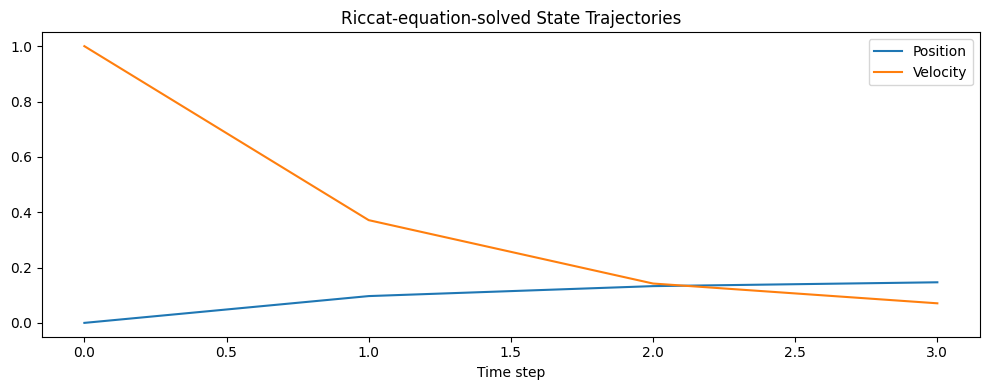

States:
 [[0.         1.        ]
 [0.09685631 0.37126203]
 [0.13283732 0.14222434]
 [0.14670236 0.07074541]]
Controls:
 [[-0.62873797]
 [-0.22903769]
 [-0.07147893]]


In [11]:
# Solve the LQR problem with the classical Riccati equation method
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are

# System definition
A = np.array([[1.0, 0.1],
        [0.0, 1.0]])
B = np.array([[0.005],
        [1.0]])
Q = np.eye(2)
R = np.array([[1.0]])
x0 = np.array([0.0, 1.0])
N = 3  # Input horizon length (state horizon would be N+1=4)

# Backward Riccati recursion to compute K_t
P = Q.copy()  # Terminal cost
K_list = []

for _ in range(N):
    S = R + B.T @ P @ B
    K = np.linalg.solve(S, B.T @ P @ A)  # K = (R + Bᵀ P B)⁻¹ Bᵀ P A
    K_list.insert(0, K)  # prepend to use forward later
    P = Q + A.T @ P @ A - A.T @ P @ B @ K  # update P for next step

# Forward rollout of trajectory
x = x0.reshape(-1, 1)
states = [x.flatten()]
controls = []

for K in K_list:
    u = -K @ x
    controls.append(u.flatten())
    x = A @ x + B @ u
    states.append(x.flatten())

states = np.array(states)
controls = np.array(controls)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(states[:, 0], label='Position')
plt.plot(states[:, 1], label='Velocity')
plt.title('Riccat-equation-solved State Trajectories')
plt.xlabel('Time step')
plt.legend()


plt.tight_layout()
plt.show()

# Optional: print values
print("States:\n", states)
print("Controls:\n", controls)
